# A demonstration of oslo_method_python


Before this notebook is run on a new system, make sure to compile the Cython files by doing (in the top repo directory):

```python setup.py build_ext --inplace```

In [1]:
%load_ext autoreload
%autoreload 2
#%matplotlib widget
# %matplotlib inline
%matplotlib notebook
import matplotlib.pyplot as plt
import numpy as np
import ompy as om
import logging
import pickle

In [2]:
# Import raw matrix into instance of om.Matrix() and plot it
raw = om.Matrix()
raw.load('data/alfna')
raw.cut_diagonal((800, 0), (7500, 7300))
raw.cut(axis='Ex', limits=[0, 6500])
raw.plot()

<IPython.core.display.Javascript object>

In [3]:
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger("ompy.unfolder")
logger.setLevel(logging.INFO)

fname_resp_mat = "data/response_matrix.m"
fname_resp_dat = "data/response_parameters.dat"

unfolder = om.Unfolder()
unfolder.load_response(fname_resp_mat)
unfolded = unfolder.unfold(raw)
unfolded.plot()

<IPython.core.display.Javascript object>

In [4]:
firstgen = om.first_generation_method(unfolded, Ex_max=6500, dE_gamma=500)
firstgen.plot(zmin=1e-3)

  warnings.warn("Hello from the fill_negative() function. Please debug me.")



<IPython.core.display.Javascript object>

In [5]:
# Do error propagation in order to obtain an error matrix on the first generation spectrum
# Note that it requires an instance of MatrixAnalysis as input
logger = logging.getLogger("ompy.ensemble")
logger.setLevel(logging.INFO)

unfolder = om.Unfolder()
unfolder.cut_diagonal((800, 0), (7500, 7300))
unfolder.load_response(fname_resp_mat)
unfolded = unfolder.unfold(raw)

N_ensemble = 100

def firstmethod(U):
    return om.first_generation_method(matrix_in=U, Ex_max=6500,
                                     dE_gamma=800,multiplicity_estimation="statistical")

ensemble = om.Ensemble(raw=raw)
ensemble.unfolder = unfolder
ensemble.first_generation_method = firstmethod
ensemble.generate(number=N_ensemble, regenerate=True)


INFO:ompy.ensemble:Generating 0
INFO:ompy.ensemble:Generating 1
INFO:ompy.ensemble:Generating 2
INFO:ompy.ensemble:Generating 3
INFO:ompy.ensemble:Generating 4
INFO:ompy.ensemble:Generating 5
INFO:ompy.ensemble:Generating 6
INFO:ompy.ensemble:Generating 7
INFO:ompy.ensemble:Generating 8
INFO:ompy.ensemble:Generating 9
INFO:ompy.ensemble:Generating 10
INFO:ompy.ensemble:Generating 11
INFO:ompy.ensemble:Generating 12
INFO:ompy.ensemble:Generating 13
INFO:ompy.ensemble:Generating 14
INFO:ompy.ensemble:Generating 15
INFO:ompy.ensemble:Generating 16
INFO:ompy.ensemble:Generating 17
INFO:ompy.ensemble:Generating 18
INFO:ompy.ensemble:Generating 19
INFO:ompy.ensemble:Generating 20
INFO:ompy.ensemble:Generating 21
INFO:ompy.ensemble:Generating 22
INFO:ompy.ensemble:Generating 23
INFO:ompy.ensemble:Generating 24
INFO:ompy.ensemble:Generating 25
INFO:ompy.ensemble:Generating 26
INFO:ompy.ensemble:Generating 27
INFO:ompy.ensemble:Generating 28
INFO:ompy.ensemble:Generating 29
INFO:ompy.ensemble:G

In [6]:
fig, ax = plt.subplots(ncols=3, sharey=True)
ensemble.std_raw.plot(ax=ax[0])
ensemble.std_unfolded.plot(ax=ax[1])
ensemble.std_firstgen.plot(ax=ax[2])
plt.tight_layout()
plt.show()

<IPython.core.display.Javascript object>

In [7]:
bin_width_out = 120#150
Ex_min = 3000
Ex_max = 6500
Eg_min = 1000

ftol = 1e-3 # Fitting tolerance (in some unknown, relative units)
maxfev = None # maximum number of function evaluations

N_fits = N_ensemble

In [8]:
std = ensemble.std_firstgen
mat = om.Matrix(ensemble.firstgen_ensemble[0],
                     Ex=std.Ex,
                     Eg=std.Eg)
fits = om.FitRhoT(mat, std, bin_width_out,
                      Ex_min, Ex_max, Eg_min,
                      method="Powell",
                      options={'disp':True, 'ftol':ftol, 'maxfev':maxfev}
                      #error_normalization="approximate"
                     )
fits.fit()
rho = fits.rho
T = fits.T

attempt decomposition
Optimization terminated successfully.
         Current function value: 16422.416016
         Iterations: 6
         Function evaluations: 8205


In [10]:
# Decomposition with the new 1Gen matrixes -- if saved, just load them again

rho_ens = []
gsf_ens = []

try:
#     nld_Earray = np.loadtxt("error_propagation_ensemble/rho_E_array.txt")
#     gsf_Earray = np.loadtxt("error_propagation_ensemble/gsf_E_array.txt")
    rho_val = np.loadtxt("error_propagation_ensemble/rho_ensemble_fits-{:d}-bin_width_{:d}.txt".format(N_fits, bin_width_out))
    gsf_val = np.loadtxt("error_propagation_ensemble/T_ensemble_fits-{:d}-bin_width_{:d}.txt".format(N_fits, bin_width_out))
    for i in range(N_fits):
    #         rho_val = np.loadtxt("error_propagation_ensemble/rho_ensemble_fits-{:d}.txt".format(i))
    #         gsf_val = np.loadtxt("error_propagation_ensemble/gsf_ensemble_fits-{:d}.txt".format(i))
        gsf_val[i,:] /= T.E**3
        rho_tmp = om.Vector(rho_val[i,:], rho.E)
        rho_ens.append(rho_tmp)
        gsf_tmp = om.Vector(gsf_val[i,:], T.E)
        gsf_ens.append(gsf_tmp)
except:
    std = ensemble.std_firstgen
    for i in range(N_fits):
        print("Start of iteration {}".format(i))
        mat = om.Matrix(ensemble.firstgen_ensemble[i],
                     Ex=std.Ex,
                     Eg=std.Eg)
        fits = om.FitRhoT(mat, std, bin_width_out,
                              Ex_min, Ex_max, Eg_min,
                              method="Powell",
                              options={'disp':True, 'ftol':ftol, 'maxfev':maxfev}
                              #error_normalization="approximate"
                             )
        fit.fits()
        rho_ens.append(fits.rho)
        T = fits.T
        gsf = T.values / (2 * np.pi * (T.E)**3)
        gsf_ens.append(om.Vector(gsf,T.E))

        np.savetxt("error_propagation_ensemble/rho_ensemble_fits-{:d}.txt".format(i), rho_ens[i].values)
        np.savetxt("error_propagation_ensemble/gsf_ensemble_fits-{:d}.txt".format(i), gsf_ens[i].values)

    np.savetxt("error_propagation_ensemble/rho_E_array.txt", rho_ens[0].E)
    np.savetxt("error_propagation_ensemble/gsf_E_array.txt", gsf_ens[0].E)

rho_ens_initial = rho_ens
gsf_ens_initial = gsf_ens

In [11]:
# Do the fits look the same (using the previously estimated 1Gen matrix and the updated version)?
def plot_nld_gsf(rho_ens, gsf_ens):
    fig, (ax1,ax2) = plt.subplots(1,2) 
    for i in range(100):
        ax1.plot(rho_ens[i].E, rho_ens[i].values, "-", label=str(i))
        ax2.plot(gsf_ens[i].E, gsf_ens[i].values, "-")
    ax1.set_yscale("log")
    ax1.legend()
    ax2.set_yscale("log")
    plt.plot()

plot_nld_gsf(rho_ens_initial, gsf_ens_initial)

<IPython.core.display.Javascript object>

In [12]:
# plot initial rho and gsf
rho_mean = np.mean([vec.values for vec in rho_ens_initial], axis=0)
gsf_mean = np.mean([vec.values for vec in gsf_ens_initial], axis=0)

rho_std = np.std([vec.values for vec in rho_ens_initial], axis=0)
gsf_std = np.std([vec.values for vec in gsf_ens_initial], axis=0)

std_rel_nld = {}
std_rel_nld["fit"] = rho_std/rho_mean

std_rel_gsf = {}
std_rel_gsf["fit"] = gsf_std/gsf_mean


fig, (ax1,ax2) = plt.subplots(1,2) 
ax1.set_yscale("log")
ax2.set_yscale("log")
ax1.errorbar(rho_ens[0].E, rho_mean, yerr=rho_std, fmt="o")
ax2.errorbar(gsf_ens[0].E, gsf_mean, yerr=gsf_std, fmt="o")

<IPython.core.display.Javascript object>

<ErrorbarContainer object of 3 artists>

In [13]:
from matplotlib import rc
rc('font',**{'family':'serif','serif':['Computer Modern Roman']})
rc('text', usetex=True)
rc('errorbar', capsize=1.5) # Set error bar style

In [14]:
import copy
# just giving it a try
alpha = 2.2
A = 1
B = 2*np.pi*0.8/8

rho_ens_initialMeV = copy.deepcopy(rho_ens_initial)
gsf_ens_initialMeV = copy.deepcopy(gsf_ens_initial)

E_array = rho_ens_initial[0].E/1e3
for i in range(len(rho_ens_initialMeV)):
    rho_ens_initialMeV[i].E = E_array
    
E_array = gsf_ens_initial[0].E/1e3
for i in range(len(rho_ens_initialMeV)):
    gsf_ens_initialMeV[i].E = E_array

rho_ens = [vec.transform(alpha=alpha, const=A) for vec in rho_ens_initialMeV]
gsf_ens = [vec.transform(alpha=alpha, const=B) for vec in gsf_ens_initialMeV]

rho_mean = np.mean([vec.values for vec in rho_ens], axis=0)
gsf_mean = np.mean([vec.values for vec in gsf_ens], axis=0)

rho_std = np.std([vec.values for vec in rho_ens], axis=0)
gsf_std = np.std([vec.values for vec in gsf_ens], axis=0)

def nld_gsf_plot(title=None):
    yscale ="log"
    fig, (ax1,ax2) = plt.subplots(1,2) 
    ax1.set_yscale(yscale)
    ax2.set_yscale(yscale)

    ax1.set_ylabel(r"$\rho \,\, (\mathrm{MeV}^{-1})$")
    ax2.set_ylabel(r"$f_1 \,\, (\mathrm{MeV}^{-3})$")

    ax1.set_xlabel(r"$E_x (\mathrm{MeV})$")
    ax2.set_xlabel(r"$E_\gamma (\mathrm{MeV})$")

    # Load and add published, normalized data:
    rho_published = np.loadtxt("data/nld_164Dy_3He_alpha_163Dy.txt", skiprows=6)
    ax1.errorbar(rho_published[:, 0], rho_published[:, 1], yerr=rho_published[:, 2],
                          fmt="<", markersize=2, color="crimson",
                          label=r"$\rho$, Nyhus $\textit{et\,\,al.}$")

    gsf_published = np.loadtxt("data/gsf_164Dy_3He_alpha_163Dy.txt", skiprows=6)
    ax2.errorbar(gsf_published[:, 0], gsf_published[:, 1], yerr=gsf_published[:, 2],
                          fmt="<", markersize=2, color="crimson",
                          label=r"$\gamma$SF, Nyhus $\textit{et\,\,al.}$")


    ax1.legend(loc="best")

    fig.suptitle(title)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    return fig, ax1, ax2

title = "Chi-by-eye"
fig, ax1, ax2 = nld_gsf_plot(title=title)
ax1.errorbar(rho_ens[0].E, rho_mean, yerr=rho_std, fmt="o")
ax2.errorbar(gsf_ens[0].E, gsf_mean, yerr=gsf_std, fmt="o")
plt.savefig("figs/chi-by-eye.pdf")
plt.show()

<IPython.core.display.Javascript object>

  (prop.get_family(), self.defaultFamily[fontext]))



In [15]:
# find_norm
Sn = 6.271

pnld_norm = {}
pnld_norm["E1_low"] = 0.
pnld_norm["E2_low"] = 1.
pnld_norm["E1_high"] = 2.5
pnld_norm["E2_high"] = 4.5
pnld_norm["nld_Sn"] = np.array([pnld_norm["E1_high"], 1.33e6])
pnld_ext = {} # automatically found for CT
pnld_ext["ext_range"] = np.array([3.5,8.]) # extrapolation range
fname_discretes = "data/discrete_levels.txt"

pspin = {}

## normalization of the gsf
# choose a spincut model and give it's parameters
#pspin["spincutModel"]="EB05"
#pspin["spincutPars"]={"mass":164, "NLDa":17.75, "Eshift":0.38} # some dummy values
pspin["spincutModel"]="Disc_and_EB05"
pspin["spincutPars"]={"mass":163, "NLDa":17.31, "Eshift":-0.84,
                      "Sn":Sn, "sigma2_disc":[1.5,3.3]}

# input parameters:
# Emid_Eg, rho_in, T_in in MeV, MeV^-1, 1
# J_target in 1
# D0 in eV
# Gg in meV
# Sn in MeV
pspin["J_target"] = 0
pspin["Gg"] = [112.,20.] # meV
pspin["Sn"] = Sn # MeV
D0 = np.array([62.,5.]) # eV, format:[mean, std] (of the A-1 nucleus(!))

rho_initial_mean = np.mean([vec.values for vec in rho_ens_initial], axis=0)
rho_initial_std = np.std([vec.values for vec in rho_ens_initial], axis=0)
nld = np.c_[rho_ens_initial[0].E*1e-3, rho_initial_mean, rho_initial_std]

# Bounds for differential evolution
# A, alpha, T
pnld_norm["bounds_diff_evo"] = [(1e-3, 100), # A
                                (1e-1, 1e1), # alpha
                                (0.1, 1), # T
                                (D0[0]*0.99,D0[0]*1.01)] #D0
normNLD = om.NormNLD(nld=nld,
                     method="find_norm", pnorm=pnld_norm,
                     nldModel="CT", pext=pnld_ext,
                     D0 = D0,
                     pspin=pspin,
                     fname_discretes=fname_discretes )

rho_fit = normNLD.nld_norm
nld_ext = normNLD.nld_ext
A_norm = normNLD.A_norm
alpha_norm = normNLD.alpha_norm
discretes = normNLD.discretes
multinest_samples = normNLD.multinest_samples


Result from find_norm / differential evolution:
      fun: 29.962776861115763
     jac: array([-0.00012825,  0.00096279, -0.00172449,  0.05236664])
 message: 'Optimization terminated successfully.'
    nfev: 2755
     nit: 42
 success: True
       x: array([ 1.77030124,  2.13041847,  0.60161775, 61.38      ])
/home/fabiobz/Desktop/Masterthesis/misc/oslo_method_python/notebooks/Dy163

 Starting multinest: this may take a while. Check also terminal output
  analysing data from multinest/nld_norm_.txt
    A              1.843 +- 0.065
    alpha          2.101 +- 0.030
    T              0.604 +- 0.011
    D0             66.2 +- 2.8


In [16]:
def tranform_nld_gsf(samples, nld_ens=None, gsf_ens=None):
    
    # TODO: NEED TO FIX A SEED HERE!, 
    # but should not effect seed of the other programs
    # -- could also ensure that the std of the sample
    # in the for loop is similar to the std of all elements...
    # otherwise replace it
    
    # Inputs
    # ------
    # samples: dict of multinest samples
    # nld_ens: (optional) list of Vectors or Vector
    # gsf_ens: (optional) list of Vectors or Vector

    # need to sweep though multinest samples at random!
    for key, value in samples.items():
        N_samples = len(value)
        break
    randlist = np.arange(N_samples)
    np.random.shuffle(randlist) # works in-place
    
    if nld_ens is not None:
        A = samples["A"]
        alpha = samples["alpha"]  
        if type(nld_ens) is om.Vector:
            N = min(N_samples, 100)
        else:
            N = len(nld_ens)
        nld_ens_trans = []

    if gsf_ens is not None:
        B = samples["B"]
        alpha = samples["alpha"]
        if type(gsf_ens) is om.Vector:
            N = min(N_samples, 100)
        else:
            N = len(gsf_ens)
        gsf_ens_trans = []
    print()                                     
    for i in range(N):
        i_multi = randlist[i]
        try:
            if type(nld_ens) is om.Vector:
                nld_tmp = nld_ens
            else:
                nld_tmp = nld_ens[i]
            nld_tmp = nld_tmp.transform(alpha=alpha[i_multi], 
                                               const=A[i_multi])
            nld_ens_trans.append(nld_tmp)
        except:
            pass
                                           
        try:
            if type(gsf_ens) is om.Vector:
                gsf_tmp = gsf_ens
            else:
                gsf_tmp = gsf_ens[i]
            gsf_tmp = gsf_tmp.transform(alpha=alpha[i_multi], 
                                               const=B[i_multi])
            gsf_ens_trans.append(gsf_tmp)
        except:
            pass
        
        
    if nld_ens is not None and gsf_ens is not None:
        return nld_ens_trans, gsf_ens_trans
    elif gsf_ens is not None:
        return gsf_ens_trans
    elif nld_ens is not None:
        return nld_ens_trans

nld_samples_transformed = tranform_nld_gsf(multinest_samples, rho_ens_initialMeV)

In [20]:
import scipy.stats as stats

# extrapolations
gsf_ext_range = np.array([0,3.,4., Sn+1])
# pext = {"method":"parameters",
# 'gsf_ext_low': np.array([  0.72980763, -19.24]),
#  'gsf_ext_high': np.array([  1.29711533, -18.15])}

pext = {"method": "chi2",
        "Elow_min": 1., "Elow_max": 2.,
        "Ehigh_min": 5.3, "Ehigh_max": 6.3}

# assumptions in normalization: swave (currently); and equal parity
normMethod="standard" #-- like in normalization.c/Larsen2011 eq (26)
# normMethod="test" # -- test derived directly from Bartolomew

gsf_ens = [vec for vec in gsf_ens_initialMeV]
gsf_mean = np.mean([vec.values for vec in gsf_ens], axis=0)
#gsf_std = np.std([vec.values for vec in gsf_ens], axis=0)

def norm_gsf_differnt_nld(rho_fit, gsf_fit, nld_ext, alpha_norm, D0, Gg=None):
    """
    Sequentially normalize gsf dependent on the parameters we got from
    the normalization of the nld    
    """
    try:
        dim = rho_fit.shape[1]
        if dim == 3:
            rho_fit_err = rho_fit[:,2]
            rho_fit_mean = rho_fit[:,1]
        elif dim == 2:
            rho_fit_mean = rho_fit[:,1]
    except IndexError:
            rho_fit_mean = rho_fit
    
    normGSF = om.NormGSF(gsf=np.c_[gsf_ens[0].E,gsf_fit],
                           method=normMethod,
                           D0=D0,
                           alpha_norm=alpha_norm,
                           pext=pext, ext_range = gsf_ext_range,
                           nld=np.c_[rho_ens[0].E,rho_fit_mean], nld_ext=nld_ext,
                           **pspin)

    normGSF.normalize_fixGg()
    
#     fig, ax = plt.subplots()
#     plt.subplots_adjust(left=0.25, bottom=0.35)
#     normGSF.plot(fig, ax, interactive=True)
#     plt.show()
    return normGSF

normGSF_mean = norm_gsf_differnt_nld(rho_fit, np.c_[gsf_mean, gsf_std], 
                                     nld_ext, alpha_norm, D0, Gg=pspin["Gg"])

integral_unc_rel, norm = normGSF_mean.normalize_Gg_chi2(nld_samples_transformed, gsf_ens_initialMeV);
print("Normalization B: {:.2f}".format(B))

[  0.95678313 -19.52503764]
[  1.5475279  -19.64102412]
here: [  0.95678313 -19.52503764]
[  0.95678313 -19.52503764]
[  1.5475279  -19.64102412]
here: [  0.95678313 -19.52503764]
[  0.95678313 -19.52503764]
[  1.5475279  -19.64102412]
here: [  0.95678313 -19.52503764]
modelGg:  [112.           9.03225806]
Normalization B: 0.63


### Test already here: Does the "new" function for simultaneous normalization work?

In [21]:
nlds, gsfs, nld_mean, gsf_mean = \
    om.normalize_simultaneous_each_member(rho_ens_initialMeV,
                                       gsf_ens_initialMeV,
                                       pnld_norm, pnld_ext, D0,
                                       pspin, fname_discretes,
                                       pext, gsf_ext_range,
                                       N_max=3,
                                       )

Result from find_norm / differential evolution:
      fun: 33.26393494422538
     jac: array([ 0.00041283,  0.00201368, -0.00338574,  0.03168594])
 message: 'Optimization terminated successfully.'
    nfev: 2000
     nit: 30
 success: True
       x: array([ 1.61637335,  2.22760723,  0.63068951, 61.38      ])
/home/fabiobz/Desktop/Masterthesis/misc/oslo_method_python/notebooks/Dy163

 Starting multinest: this may take a while. Check also terminal output
  analysing data from multinest/nld_norm_.txt
    A              1.682 +- 0.061
    alpha          2.175 +- 0.065
    T              0.624 +- 0.023
    D0             65.3 +- 2.7
[  0.55136096 -18.80928825]
[  1.42813268 -18.45438966]
here: [  0.55136096 -18.80928825]

 Attempt iteration nr 0
[  0.55136096 -18.80928825]
[  1.42813268 -18.45438966]
here: [  0.55136096 -18.80928825]
modelGg:  [112.           9.03225806]
Result from find_norm / differential evolution:
      fun: array([33.24426943])
     jac: array([-2.20268248e-05,  4.5190

<IPython.core.display.Javascript object>


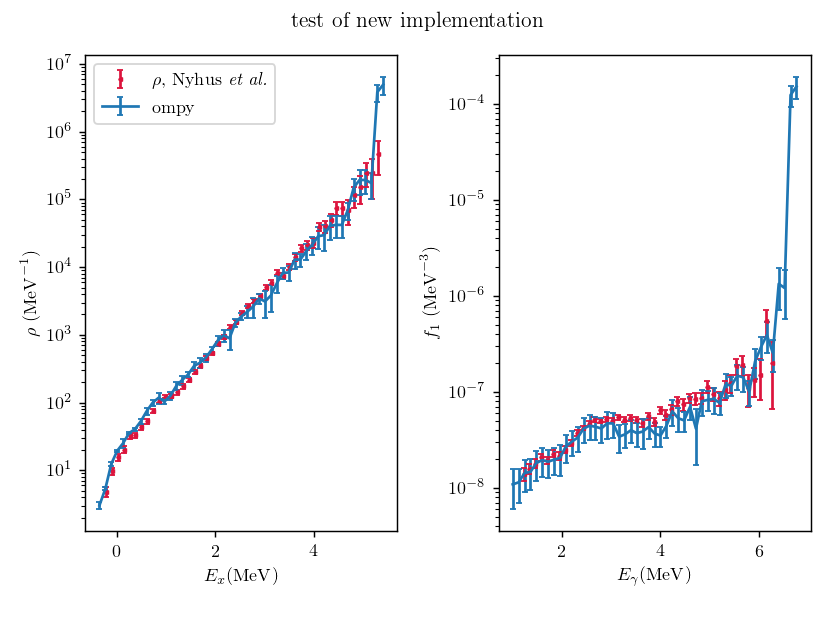

[]

In [24]:
fig, ax1, ax2 = nld_gsf_plot(title="test of new implementation")
ax1.errorbar(rho_ens_initialMeV[0].E, nld_mean[:,0], 
             yerr=nld_mean[:,1], label="ompy")
ax2.errorbar(gsf_ens_initialMeV[0].E, gsf_mean[:,0], 
             yerr=gsf_mean[:,1])
ax1.legend()
plt.plot()

# REST BELOW HERE CURRENTLY Might NOT WORK!


## A) Normalize NLD and GSF sequentially

#### 1) Normalize ensemble mean with uncertainty

<IPython.core.display.Javascript object>


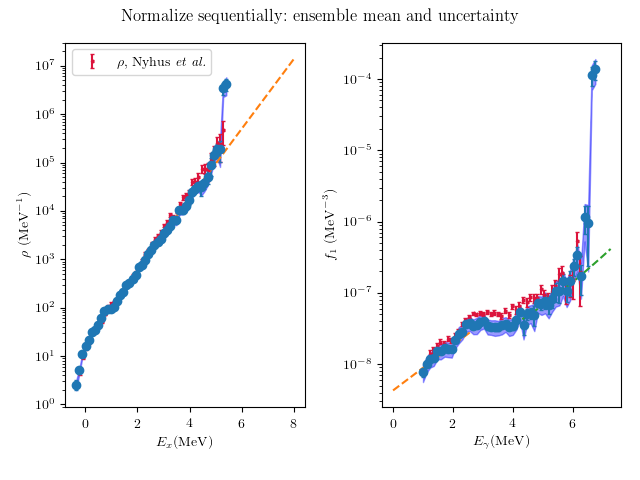

In [19]:
title = "Normalize sequentially: ensemble mean and uncertainty"
fig, ax1, ax2 = nld_gsf_plot(title=title)

gsf_ext_low = normGSF_mean.gsf_ext_low
gsf_ext_high = normGSF_mean.gsf_ext_high
gsf_fit = normGSF_mean.gsf

ax1.errorbar(rho_fit[:,0],rho_fit[:,1],
             yerr=rho_fit[:,1]*std_rel_nld["fit"],
             fmt="o",
             label=r"ompy results, normalized")
ax1.fill_between(rho_fit[:,0], 
                 rho_fit[:,1] - rho_fit[:,2], 
                 rho_fit[:,1] + rho_fit[:,2],
                 color='blue', alpha=0.4,
                 label="unc. including normalization")
ax1.plot(nld_ext[:,0],nld_ext[:,1],"--")

ax2.errorbar(gsf_fit[:,0],gsf_fit[:,1],
             yerr=gsf_fit[:,1]*std_rel_gsf["fit"],
             fmt="o")
ax2.fill_between(gsf_fit[:,0], 
                 gsf_fit[:,1] - gsf_fit[:,2], 
                 gsf_fit[:,1] + gsf_fit[:,2],
                 color='blue', alpha=0.4)
ax2.plot(gsf_ext_low[:,0],gsf_ext_low[:,1],"--")
ax2.plot(gsf_ext_high[:,0],gsf_ext_high[:,1],"--")


plt.savefig("figs/seq_ensemble_mean.pdf")
plt.show()

all_fits = dict()
all_fits["seq_mean"] = dict()
all_fits["seq_mean"]["rho_fit"] = rho_fit
all_fits["seq_mean"]["gsf_ext_low"] = normGSF_mean.gsf_ext_low
all_fits["seq_mean"]["gsf_ext_high"] = normGSF_mean.gsf_ext_high
all_fits["seq_mean"]["gsf"]= gsf_fit

#### 2) Normalize each ensembel member separately (no individ uncertainty)

In [20]:
# normalize each nld and GSF separately
nlds = []
nld_exts = []
gsfs = []
N_fits_norm = 20
for i in range(N_fits_norm):
    print("\n Attempt iteration nr {}".format(i))
    nld = np.c_[rho_ens_initial[0].E*1e-3, rho_ens_initial[i].values, np.ones_like(rho_ens_initial[0].values)]
    
    # Bounds for differential evolution
    # A, alpha, T
    pnld_norm["bounds_diff_evo"] = [(1e-3, 100), # A
                                    (1e-1, 1e1), # alpha
                                    (0.1, 1), # T
                                    (D0[0]*0.99,D0[0]*1.01)] #D0

    normNLD = om.NormNLD(nld=nld,
                         method="find_norm", pnorm=pnld_norm,
                         nldModel="CT", pext=pnld_ext,
                         D0 = D0,
                         pspin=pspin,
                         fname_discretes=fname_discretes )

    rho_fit = normNLD.nld_norm
    nld_ext = normNLD.nld_ext
    A_norm = normNLD.A_norm
    alpha_norm = normNLD.alpha_norm
    discretes = normNLD.discretes
    multinest_samples = normNLD.multinest_samples

    nlds.append(rho_fit)
    nld_exts.append(nld_ext)
    
    gsf_fit = gsf_ens_initialMeV[i].values
    normGSF = norm_gsf_differnt_nld(rho_fit, gsf_fit, nld_ext, alpha_norm, D0, Gg=pspin["Gg"])
    
    gsf = normGSF.gsf
    gsfs.append(gsf)


 Attempt iteration nr 0
Result from find_norm / differential evolution:
      fun: 33.26393494329925
     jac: array([-0.00032259, -0.00102247,  0.00257643,  0.03167244])
 message: 'Optimization terminated successfully.'
    nfev: 2060
     nit: 31
 success: True
       x: array([ 1.61637483,  2.22760471,  0.63068905, 61.38      ])
/home/fabiobz/Desktop/Masterthesis/misc/oslo_method_python/notebooks/Dy163

 Starting multinest: this may take a while. Check also terminal output
  analysing data from multinest/nld_norm_.txt
    A              1.621 +- 0.093
    alpha          2.223 +- 0.087
    T              0.629 +- 0.029
    D0             61.7 +- 5.0

 Attempt iteration nr 1
Result from find_norm / differential evolution:
      fun: 58.30115751955364
     jac: array([-0.00716369, -0.00822951,  0.0097458 ,  0.02847145])
 message: 'Optimization terminated successfully.'
    nfev: 2235
     nit: 35
 success: True
       x: array([ 1.52776344,  2.05237082,  0.56924172, 61.54254635])
/hom

  analysing data from multinest/nld_norm_.txt
    A              1.97 +- 0.12
    alpha          2.087 +- 0.085
    T              0.604 +- 0.027
    D0             61.8 +- 5.0

 Attempt iteration nr 13
Result from find_norm / differential evolution:
      fun: 30.95574043181849
     jac: array([ 2.08189022e-04, -2.70006240e-05, -2.50111043e-04,  4.89272622e-02])
 message: 'Optimization terminated successfully.'
    nfev: 2235
     nit: 34
 success: True
       x: array([ 1.73647953,  2.1860645 ,  0.62148392, 61.38      ])
/home/fabiobz/Desktop/Masterthesis/misc/oslo_method_python/notebooks/Dy163

 Starting multinest: this may take a while. Check also terminal output
  analysing data from multinest/nld_norm_.txt
    A              1.74 +- 0.11
    alpha          2.185 +- 0.092
    T              0.620 +- 0.029
    D0             62.4 +- 4.8

 Attempt iteration nr 14
Result from find_norm / differential evolution:
      fun: 28.848208746290993
     jac: array([3.01980663e-05, 5.75539616

<IPython.core.display.Javascript object>


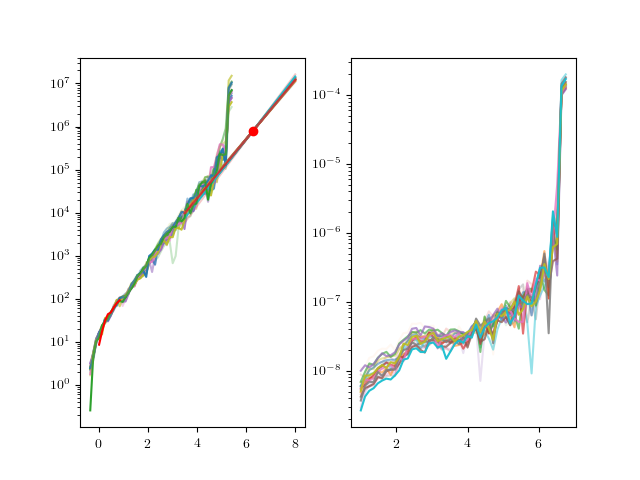

In [21]:
fig, (ax1,ax2) = plt.subplots(1,2) 
for i in range(N_fits_norm):
    ax1.semilogy(nlds[i][:,0],nlds[i][:,1], alpha=0.05*i+0.2)
    ax1.semilogy(nld_exts[i][:,0],nld_exts[i][:,1], alpha=0.05*i+0.2)
    ax2.semilogy(gsfs[i][:,0],gsfs[i][:,1], alpha=0.05*i)

i=0
nld = np.c_[rho_ens_initial[0].E*1e-3, rho_ens_initial[i].values, np.ones_like(rho_ens_initial[0].values)]
nldSn = normNLD.nldSn_from_D0(D0, pspin["Sn"], pspin["J_target"],
                      spincutModel=pspin["spincutModel"], spincutPars=pspin["spincutPars"])
ax1.errorbar(nldSn[0],nldSn[1][0],yerr=D0[1]/D0[0]*nldSn[1][0], fmt="ro")

ax1.plot(discretes[:,0], discretes[:,1],"r")

plt.show()

<IPython.core.display.Javascript object>


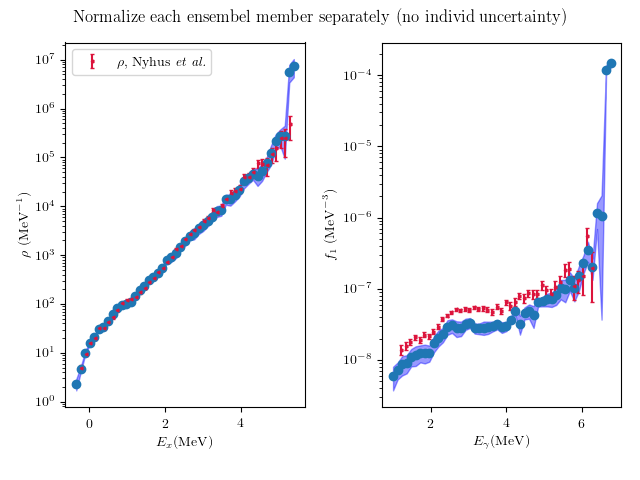

In [22]:
# plots for normalization of each combination separately
nlds_arr = np.array(nlds)
gsfs_arr = np.array(gsfs)

rho_mean = np.mean(nlds_arr[:,:,1], axis=0)
gsf_mean = np.mean(gsfs_arr[:,:,1], axis=0)

rho_std = np.std(nlds_arr[:,:,1], axis=0)
gsf_std = np.std(gsfs_arr[:,:,1], axis=0)

rho_fit = np.c_[rho_ens[0].E, 
                rho_mean, 
                rho_std]
gsf_fit = np.c_[gsf_ens[0].E, 
                gsf_mean, 
                gsf_std]


def plot_points_band(ax1, ax2, rho_fit, gsf_fit):
    ax1.plot(rho_fit[:,0], 
                 rho_fit[:,1],
                 "o",
                 label=r"ompy results, normalized")
    ax1.fill_between(rho_fit[:,0], 
                     rho_fit[:,1] - rho_fit[:,2], 
                     rho_fit[:,1] + rho_fit[:,2],
                     color='blue', alpha=0.4,
                     label="uncertainty")

    ax2.plot(gsf_fit[:,0], 
                 gsf_fit[:,1],
                 "o")
    ax2.fill_between(gsf_fit[:,0], 
                 gsf_fit[:,1] - gsf_fit[:,2], 
                 gsf_fit[:,1] + gsf_fit[:,2],
                     color='blue', alpha=0.4)


title = "Normalize each ensembel member separately (no individ uncertainty)"
fig, ax1, ax2 = nld_gsf_plot(title=title)


plot_points_band(ax1, ax2, rho_fit, gsf_fit)
# ax1.plot(nld_ext[:,0],nld_ext[:,1],"--")
# ax2.plot(gsf_ext_low[:,0],gsf_ext_low[:,1],"--")
# ax2.plot(gsf_ext_high[:,0],gsf_ext_high[:,1],"--")


plt.savefig("figs/seq_each_member.pdf")
plt.show()

all_fits["seq_each_member"] = dict()
all_fits["seq_each_member"]["rho_fit"] = rho_fit
all_fits["seq_each_member"]["gsf_ext_low"] = normGSF_mean.gsf_ext_low
all_fits["seq_each_member"]["gsf_ext_high"] = normGSF_mean.gsf_ext_high
all_fits["seq_each_member"]["gsf"]= gsf_fit

#### 2) Normalize each ensembel member separately (but with uncertainty from enseble)
this is somewhat contradictory, but it why not try. Why contradict? -> I normalize each memeber separatly because I assume that I should not have a valid ensemble uncertainty in the degenerate room

In [23]:
# normalize each nld and GSF separately -- but with uncertainties from ensemble
nlds = []
nld_exts = []
gsfs = []
for i in range(N_fits_norm):
    print("\n Attempt iteration nr {}".format(i))
    nld = np.c_[rho_ens_initial[0].E*1e-3, rho_ens_initial[i].values, rho_initial_std]
    
    # Bounds for differential evolution
    # A, alpha, T
    pnld_norm["bounds_diff_evo"] = [(1e-3, 100), # A
                                    (1e-1, 1e1), # alpha
                                    (0.1, 1), # T
                                    (D0[0]*0.99,D0[0]*1.01)] #D0

    normNLD = om.NormNLD(nld=nld,
                         method="find_norm", pnorm=pnld_norm,
                         nldModel="CT", pext=pnld_ext,
                         D0 = D0,
                         pspin=pspin,
                         fname_discretes=fname_discretes )

    rho_fit = normNLD.nld_norm
    nld_ext = normNLD.nld_ext
    A_norm = normNLD.A_norm
    alpha_norm = normNLD.alpha_norm
    discretes = normNLD.discretes
    multinest_samples = normNLD.multinest_samples

    nlds.append(rho_fit)
    nld_exts.append(nld_ext)
    
    gsf_fit = gsf_ens_initialMeV[i].values
    normGSF = norm_gsf_differnt_nld(rho_fit, gsf_fit, nld_ext, alpha_norm, D0, Gg=pspin["Gg"])
    
    gsf = normGSF.gsf
    gsfs.append(gsf)


 Attempt iteration nr 0
Result from find_norm / differential evolution:
      fun: 44.168885176325915
     jac: array([ 0.00043983,  0.00011298, -0.00075957,  0.03784777])
 message: 'Optimization terminated successfully.'
    nfev: 2480
     nit: 39
 success: True
       x: array([ 1.64955588,  2.18617269,  0.61721585, 61.80148865])
/home/fabiobz/Desktop/Masterthesis/misc/oslo_method_python/notebooks/Dy163

 Starting multinest: this may take a while. Check also terminal output
  analysing data from multinest/nld_norm_.txt
    A              1.652 +- 0.076
    alpha          2.187 +- 0.035
    T              0.617 +- 0.013
    D0             61.9 +- 4.6

 Attempt iteration nr 1
Result from find_norm / differential evolution:
      fun: 99.3339479407178
     jac: array([-2.93454150e-03,  6.63504807e-03, -3.55271368e-05,  3.41472628e-02])
 message: 'Optimization terminated successfully.'
    nfev: 2185
     nit: 33
 success: True
       x: array([ 1.5584001 ,  2.02621185,  0.56540181, 61

  analysing data from multinest/nld_norm_.txt
    A              1.99 +- 0.11
    alpha          2.075 +- 0.038
    T              0.601 +- 0.013
    D0             61.8 +- 4.9

 Attempt iteration nr 13
Result from find_norm / differential evolution:
      fun: 46.60668227346679
     jac: array([-0.0026823 , -0.0118952 ,  0.04331895,  0.05195915])
 message: 'Optimization terminated successfully.'
    nfev: 2065
     nit: 32
 success: True
       x: array([ 1.81001228,  2.11207834,  0.60140901, 62.38032336])
/home/fabiobz/Desktop/Masterthesis/misc/oslo_method_python/notebooks/Dy163

 Starting multinest: this may take a while. Check also terminal output
  analysing data from multinest/nld_norm_.txt
    A              1.819 +- 0.089
    alpha          2.115 +- 0.038
    T              0.600 +- 0.013
    D0             61.5 +- 5.0

 Attempt iteration nr 14
Result from find_norm / differential evolution:
      fun: 49.74369470038236
     jac: array([-0.00058265, -0.00136282,  0.00378435,  0

<IPython.core.display.Javascript object>


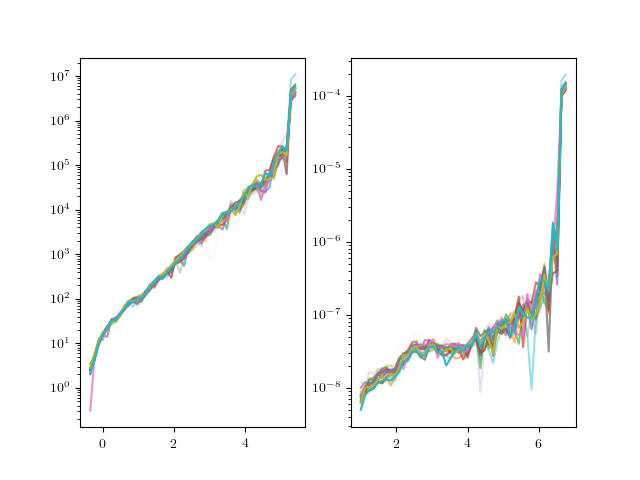

In [24]:
fig, (ax1,ax2) = plt.subplots(1,2) 
for i in range(N_fits_norm):
    ax1.semilogy(nlds[i][:,0],nlds[i][:,1], alpha=0.05*i)
    ax2.semilogy(gsfs[i][:,0],gsfs[i][:,1], alpha=0.05*i)
plt.show()

<IPython.core.display.Javascript object>


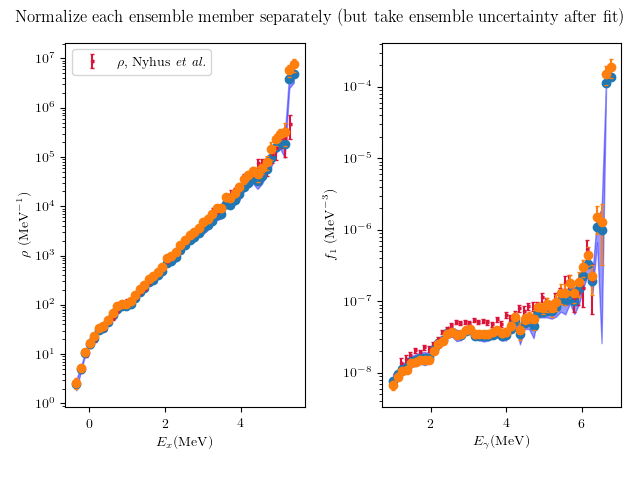

In [25]:
# plots for normalization of each combination separately
nlds_arr = np.array(nlds)
gsfs_arr = np.array(gsfs)

rho_mean = np.mean(nlds_arr[:,:,1], axis=0)
gsf_mean = np.mean(gsfs_arr[:,:,1], axis=0)

rho_std = np.std(nlds_arr[:,:,1], axis=0)
gsf_std = np.std(gsfs_arr[:,:,1], axis=0)

####

rho_fit = np.c_[rho_ens[0].E, 
                rho_mean, 
                rho_std]
gsf_fit = np.c_[gsf_ens[0].E, 
                gsf_mean, 
                gsf_std]

title = "Normalize each ensemble member separately (but take ensemble uncertainty after fit)"
fig, ax1, ax2 = nld_gsf_plot(title=title)

plot_points_band(ax1, ax2, rho_fit, gsf_fit)
# ax1.plot(nld_ext[:,0],nld_ext[:,1],"--")
# ax2.plot(gsf_ext_low[:,0],gsf_ext_low[:,1],"--")
# ax2.plot(gsf_ext_high[:,0],gsf_ext_high[:,1],"--")

plt.savefig("figs/seq_each_member_sic_but_uncertainty.pdf")
plt.show()

all_fits["seq_each_member_sic_w_unc"] = dict()
all_fits["seq_each_member_sic_w_unc"]["rho_fit"] = rho_fit
all_fits["seq_each_member_sic_w_unc"]["gsf_ext_low"] = normGSF_mean.gsf_ext_low
all_fits["seq_each_member_sic_w_unc"]["gsf_ext_high"] = normGSF_mean.gsf_ext_high
all_fits["seq_each_member_sic_w_unc"]["gsf"]= gsf_fit

### B) Normalize NLD and GSF simultaneously
#### 1) Norm ensemble mean with uncertainty

In [26]:
gsf_fit = normGSF_mean.gsf

chi2_args = normNLD.chi2_args
pext_nld = normNLD.pext

rho_mean = np.mean([vec.values for vec in rho_ens_initialMeV], axis=0)
gsf_mean = np.mean([vec.values for vec in gsf_ens_initialMeV], axis=0)
rho_std = np.std([vec.values for vec in rho_ens_initialMeV], axis=0)
gsf_std = np.std([vec.values for vec in gsf_ens_initialMeV], axis=0)

nld = np.c_[rho_fit[:,0],rho_mean,rho_std]
gsf = np.c_[gsf_fit[:,0],gsf_mean,gsf_std]
gsf_ext_low = normGSF_mean.gsf_ext_low
gsf_ext_high = normGSF_mean.gsf_ext_high
sigma_integral_rel = integral_unc_rel
Gg = pspin["Gg"]
nldModel="CT"

args = (normGSF_mean, nld, chi2_args, pext_nld, nldModel,
        gsf, gsf_ext_low, gsf_ext_high,
        sigma_integral_rel, Gg)

object_fun = normGSF_mean.chi2_nld_gsf

bounds = np.array([(0.1, 10), # A
             (0.5, 3), # alpha
             (0.4, 0.7), # T
             (D0[0]*0.98,D0[0]*1.02), #D0 -- need to keep fixed for diff evo
             (norm*1e-1,norm*1e1)]) #B

popt_simultan, multinest_samples_simultan = normGSF_mean.normalize_nld_gsf_simultan(args,bounds,D0)

  logy = np.log(yy)



Result from find_norm / differential evolution:
      fun: array([38.78884473])
     jac: array([-0.0006267 , -0.00131308,  0.00921077,  0.07607639,  0.00091163])
 message: 'Optimization terminated successfully.'
    nfev: 2592
     nit: 31
 success: True
       x: array([ 1.6393869 ,  2.22162222,  0.62313918, 60.76      ,  0.60158929])
/home/fabiobz/Desktop/Masterthesis/misc/oslo_method_python/notebooks/Dy163

 Starting multinest: this may take a while. Check also terminal output
  analysing data from multinest/nld_gsf_norm_.txt
    A              1.656 +- 0.080
    alpha          2.210 +- 0.041
    T              0.621 +- 0.014
    D0             61.3 +- 5.0
    B              0.63 +- 0.20


<IPython.core.display.Javascript object>


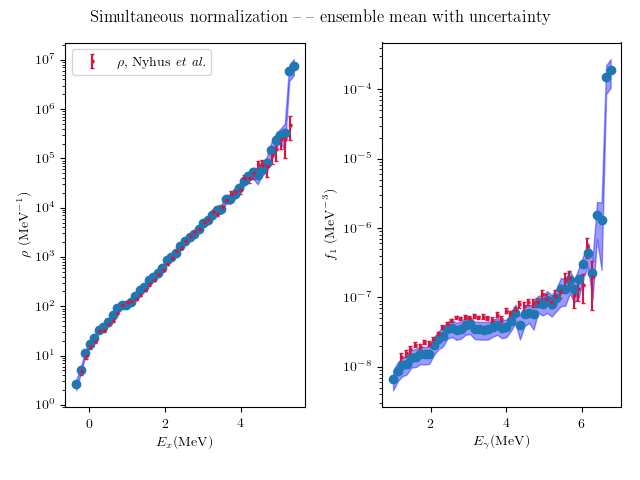

In [27]:
nld_samples_sim, gsf_samples_sim = tranform_nld_gsf(multinest_samples_simultan, 
                                                    rho_ens_initialMeV,
                                                    gsf_ens_initialMeV)

rho_mean = np.mean([vec.values for vec in nld_samples_sim], axis=0)
gsf_mean = np.mean([vec.values for vec in gsf_samples_sim], axis=0)

rho_std = np.std([vec.values for vec in nld_samples_sim], axis=0)
gsf_std = np.std([vec.values for vec in gsf_samples_sim], axis=0)

####

rho_fit = np.c_[rho_ens[0].E, 
                rho_mean, 
                rho_std]
gsf_fit = np.c_[gsf_ens[0].E, 
                gsf_mean, 
                gsf_std]

title = "Simultaneous normalization -- -- ensemble mean with uncertainty"

ax1.errorbar(rho_ens[0].E,
             rho_mean,
             yerr=rho_mean*std_rel_nld["fit"],
             fmt="o",
             label=r"ompy results, normalized")

ax2.errorbar(gsf_ens[0].E, 
             gsf_mean,
             yerr=gsf_mean*std_rel_gsf["fit"],
             fmt="o")

fig, ax1, ax2 = nld_gsf_plot(title=title)



plot_points_band(ax1, ax2, rho_fit, gsf_fit)
# ax1.plot(nld_ext[:,0],nld_ext[:,1],"--")
# ax2.plot(gsf_ext_low[:,0],gsf_ext_low[:,1],"--")
# ax2.plot(gsf_ext_high[:,0],gsf_ext_high[:,1],"--")


plt.savefig("figs/simultan_mean.pdf")
plt.show()

all_fits["sim_mean"] = dict()
all_fits["sim_mean"]["rho_fit"] = rho_fit
all_fits["sim_mean"]["gsf_ext_low"] = normGSF_mean.gsf_ext_low
all_fits["sim_mean"]["gsf_ext_high"] = normGSF_mean.gsf_ext_high
all_fits["sim_mean"]["gsf"]= gsf_fit

In [28]:
# normalize each ensemble member separately
nlds = []
nld_exts = []
gsfs = []
nld_samples_sims = []
gsf_samples_sims = []
for i in range(N_fits_norm):
    print("\n Attempt iteration nr {}".format(i))
    nld = np.c_[rho_ens_initial[0].E*1e-3, rho_ens_initial[i].values, np.ones_like(rho_ens_initial[0].values)]
    gsf = np.c_[gsf_fit[:,0],gsf_ens_initialMeV[i].values,np.ones_like(rho_ens_initial[0].values)]
    
    gsf_ext_low = normGSF_mean.gsf_ext_low
    gsf_ext_high = normGSF_mean.gsf_ext_high
    sigma_integral_rel = integral_unc_rel
    Gg = pspin["Gg"]
    nldModel="CT"

    args = (normGSF_mean, nld, chi2_args, pext_nld, nldModel,
            gsf, gsf_ext_low, gsf_ext_high,
            sigma_integral_rel, Gg)

    object_fun = normGSF_mean.chi2_nld_gsf
    
    bounds = np.array([(0.1, 10), # A
                 (0.5, 3), # alpha
                 (0.4, 0.7), # T
                 (D0[0]*0.98,D0[0]*1.02), #D0 -- need to keep fixed for diff evo
                 (norm*1e-1,norm*1e1)]) #B

    popt_simultan, multinest_samples_simultan = normGSF_mean.normalize_nld_gsf_simultan(args,bounds,D0)
    
    nld_samples_sim, gsf_samples_sim = tranform_nld_gsf(multinest_samples_simultan, 
                                                    rho_ens_initialMeV[i],
                                                    gsf_ens_initialMeV[i])

    rho_mean = np.mean([vec.values for vec in nld_samples_sim], axis=0)
    gsf_mean = np.mean([vec.values for vec in gsf_samples_sim], axis=0)
    
    nld_samples_sims.append([vec.values for vec in nld_samples_sim])
    gsf_samples_sims.append([vec.values for vec in gsf_samples_sim])
    

#     rho_std = np.std([vec.values for vec in nld_samples_sim], axis=0)
#     gsf_std = np.std([vec.values for vec in gsf_samples_sim], axis=0)
    
    nlds.append(rho_mean)
#   nld_exts.append(nld_ext)
    gsfs.append(gsf_mean)


 Attempt iteration nr 0
Result from find_norm / differential evolution:
      fun: array([38.78884472])
     jac: array([ 4.50484094e-04,  5.23669996e-04, -2.37321274e-04,  7.60863372e-02,
        9.66338121e-05])
 message: 'Optimization terminated successfully.'
    nfev: 3108
     nit: 37
 success: True
       x: array([ 1.63938779,  2.22162274,  0.62313933, 60.76      ,  0.62210128])
/home/fabiobz/Desktop/Masterthesis/misc/oslo_method_python/notebooks/Dy163

 Starting multinest: this may take a while. Check also terminal output
  analysing data from multinest/nld_gsf_norm_.txt
    A              1.658 +- 0.081
    alpha          2.209 +- 0.043
    T              0.621 +- 0.014
    D0             61.2 +- 4.9
    B              0.67 +- 0.21


 Attempt iteration nr 1
Result from find_norm / differential evolution:
      fun: array([38.78884472])
     jac: array([ 1.10134124e-04,  2.55084842e-04, -2.33058017e-04,  7.60884689e-02,
       -1.35003120e-05])
 message: 'Optimization termina

Result from find_norm / differential evolution:
      fun: array([38.78884472])
     jac: array([ 8.59756710e-05,  7.63122898e-04, -2.16573426e-03,  7.60891794e-02,
        8.10018719e-05])
 message: 'Optimization terminated successfully.'
    nfev: 2814
     nit: 33
 success: True
       x: array([ 1.6393866 ,  2.22162285,  0.62313926, 60.76      ,  0.60197634])
/home/fabiobz/Desktop/Masterthesis/misc/oslo_method_python/notebooks/Dy163

 Starting multinest: this may take a while. Check also terminal output
  analysing data from multinest/nld_gsf_norm_.txt
    A              1.656 +- 0.080
    alpha          2.213 +- 0.043
    T              0.621 +- 0.014
    D0             61.2 +- 4.9
    B              0.65 +- 0.19


 Attempt iteration nr 12
Result from find_norm / differential evolution:
      fun: array([38.78884482])
     jac: array([ 0.00117453,  0.01497042, -0.07019381,  0.076205  ,  0.00118021])
 message: 'Optimization terminated successfully.'
    nfev: 2760
     nit: 33
 suc

<IPython.core.display.Javascript object>


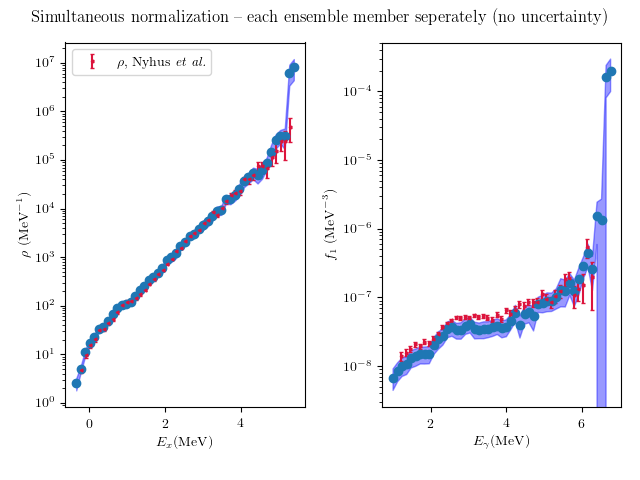

<IPython.core.display.Javascript object>


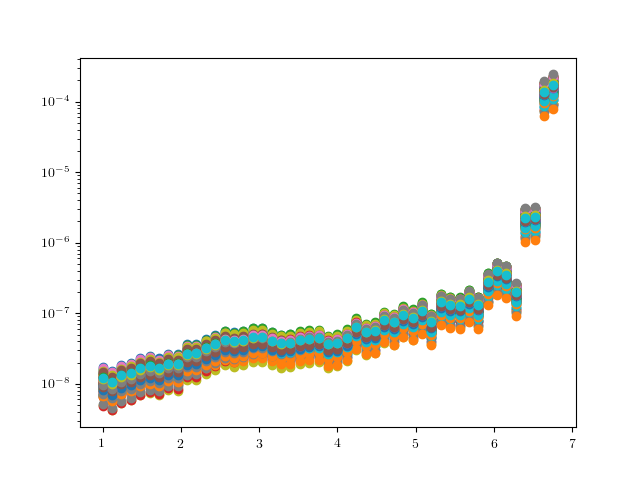

[2.60371453e-07 1.51226063e-06 1.34634724e-06 1.59812580e-04] [1.35422525e-07 9.22076991e-07 1.35536507e-06 7.93683773e-05]
[ 1.24948929e-07  5.90183640e-07 -9.01782784e-09  8.04442028e-05]
1.5122606307873133e-06
9.220769907112987e-07
1.3463472425781527e-06
1.355365070423081e-06


In [29]:
nlds_arr = np.array(nld_samples_sims)
gsfs_arr = np.array(gsf_samples_sims)

nlds_arr = nlds_arr.reshape(nlds_arr.shape[:-3] + (-1, len(rho_ens[0].E)))
gsfs_arr = gsfs_arr.reshape(gsfs_arr.shape[:-3] + (-1, len(gsf_ens[0].E)))

rho_mean = np.mean(nlds_arr, axis=0)
gsf_mean = np.mean(gsfs_arr, axis=0)

rho_std = np.std(nlds_arr, axis=0)
gsf_std = np.std(gsfs_arr, axis=0)

####

rho_fit = np.c_[rho_ens[0].E, 
                rho_mean, 
                rho_std]
gsf_fit = np.c_[gsf_ens[0].E, 
                gsf_mean, 
                gsf_std]

title = "Simultaneous normalization -- each ensemble member seperately (no uncertainty)"
fig, ax1, ax2 = nld_gsf_plot(title=title)

plot_points_band(ax1, ax2, rho_fit, gsf_fit)
# ax1.plot(nld_ext[:,0],nld_ext[:,1],"--")
# ax2.plot(gsf_ext_low[:,0],gsf_ext_low[:,1],"--")
# ax2.plot(gsf_ext_high[:,0],gsf_ext_high[:,1],"--")

plt.savefig("figs/simultan_each_member.pdf")
plt.show()

all_fits["sim_each_member"] = dict()
all_fits["sim_each_member"]["rho_fit"] = rho_fit
all_fits["sim_each_member"]["gsf_ext_low"] = normGSF_mean.gsf_ext_low
all_fits["sim_each_member"]["gsf_ext_high"] = normGSF_mean.gsf_ext_high
all_fits["sim_each_member"]["gsf"]= gsf_fit

###############
fig, ax = plt.subplots()
for i in range(100):
    plt.semilogy(gsf_fit[:,0], gsfs_arr[i],"o")
#     plt.semilogy(gsf_fit[:,0], gsfs_arr[i,:]-gsf_std, "--")
    plt.show()

# print(gsf_fit[-5:-2,:])
print(gsf_fit[-5:-1,1], gsf_std[-5:-1])
print(gsf_fit[-5:-1,1]- gsf_std[-5:-1])

# fig, ax = plt.subplots()
# ax.plot(gsfs_arr[:,-2])
# plt.show()
print(gsfs_arr[:,-4].mean())
print(gsfs_arr[:,-4].std())

print(gsfs_arr[:,-3].mean())
print(gsfs_arr[:,-3].std())

seq_mean
0.19678820791422355
0.3065206280891535 

seq_each_member
0.20969320941509673
0.2550968991783034 

seq_each_member_sic_w_unc
0.17023862414576188
0.21299820032722525 

sim_mean
0.19561788337431313
0.33892593420734535 

sim_each_member
0.21349098308918343
0.3343891502778133 



<IPython.core.display.Javascript object>


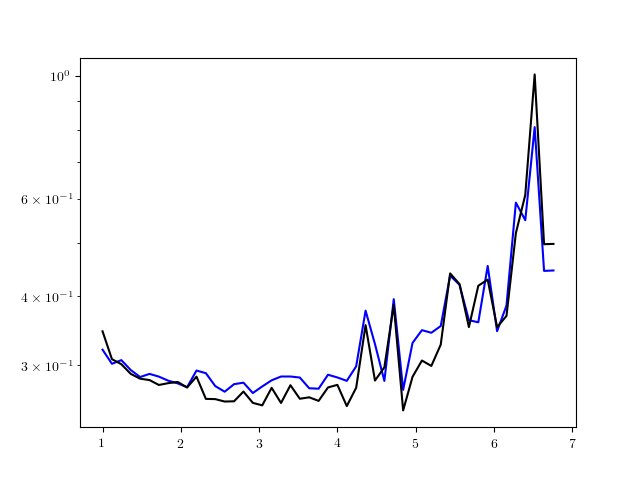

In [30]:
for key, value in all_fits.items():
    print(key)
    mean_err = np.mean(value["rho_fit"][:,2] / value["rho_fit"][:,1])
    print(mean_err)
    mean_err = np.mean(value["gsf"][:,2] / value["gsf"][:,1])
    print(mean_err, "\n")

fig, ax1 = plt.subplots()
# gsf = all_fits["sim_mean"]["gsf"]
# ax1.semilogy(gsf[:,0],gsf[:,1])

# gsf = all_fits["sim_each_member"]["gsf"]
# ax1.plot(gsf[:,0],gsf[:,1])

gsf = all_fits["sim_mean"]["gsf"]
ax1.semilogy(gsf[:,0],gsf[:,2]/gsf[:,1], "b")

gsf = all_fits["sim_each_member"]["gsf"]
ax1.plot(gsf[:,0],gsf[:,2]/gsf[:,1], "k")


# gsf = all_fits["seq_mean"]["gsf"]
# ax1.plot(gsf[:,0],gsf[:,2], "b")

# gsf = all_fits["each_member"]["gsf"]
# ax1.plot(gsf[:,0],gsf[:,2], "k")